# Deskewing
When working with [oblique plane light sheet microscopy](https://elifesciences.org/articles/57681), [single objective light sheet microscopy](https://andrewgyork.github.io/high_na_single_objective_lightsheet/) and [lattice-light sheet microscopy](https://en.wikipedia.org/wiki/Lattice_light-sheet_microscopy), a special image processing step is necessary to reconstruct the image data. This processing step is called "deskewing". Since version 0.14.0, pyclesperanto_prototype has a function for that.

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle

cle.get_device()

<NVIDIA GeForce RTX 3080 on Platform: NVIDIA CUDA (1 refs)>

## What you need to know before deskewing
When deskewing a dataset, the voxel sizes and the deskewing angle must be known. Ask your microscopist if these values are unknown. The resulting dataset will later be isotropic and have a voxel size like the original dataset along the X axis.

In [2]:
voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

The example image data shown below was kindly provided by 
[Ms Cindy Evelyn](https://imaging.wehi.edu.au/about-us/niall-geoghegan) and [Dr Niall Geoghegan](https://imaging.wehi.edu.au/about-us/niall-geoghegan) from the [Centre for Dynamic Imaging, WEHI, Melbourne, Australia](https://imaging.wehi.edu.au/) who used lattice light sheet microscopy to capture red blood cells and study the [malaria parasite invasion process](https://www.nature.com/articles/s41467-021-23626-7). The data is acquired using a Zeiss lattice lightsheet microscope.

In these so called raw data images taken with single-objective light sheet microscopes, the Z-plane is swept through the sample in a tilted way. This is not obvious when studying the Z-planes of the given stack:

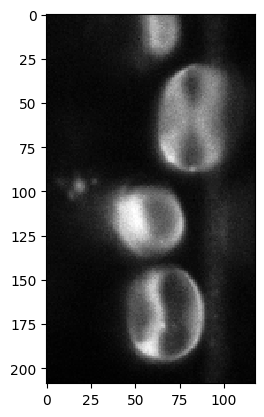

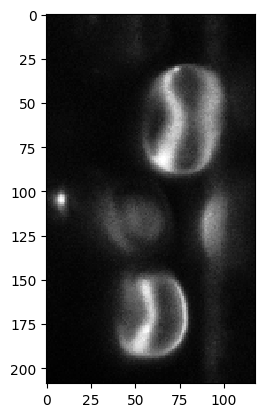

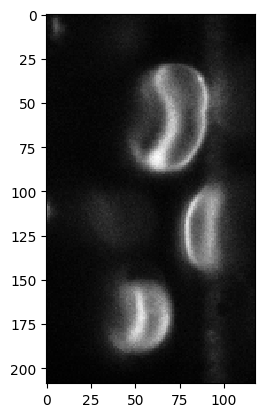

In [3]:
original_image = cle.transpose_xy(imread('../../data/RBC_tiny.tif'))
original_image.shape

cle.imshow(original_image[0])
cle.imshow(original_image[5])
cle.imshow(original_image[10])

When looking at this image stack from the side, one can see the tilt of the light sheet orientation.

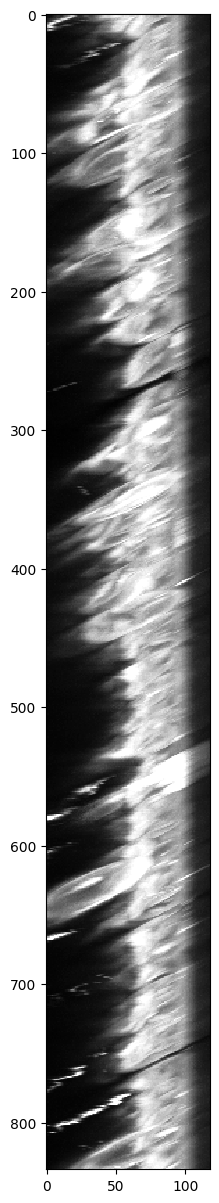

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

cle.imshow(cle.maximum_y_projection(original_image), plot=axs)

## Deskewing in action
Removing this tilt from the raw data is technially a [shearing](https://en.wikipedia.org/wiki/Shear_matrix), which is a rather uncommon part of an [affine transform](https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation).

In pyclesperanto, we have a `deskew_x()` function that takes an input image and the sweep-angle as input:

In [5]:
deskewed = cle.deskew_x(original_image, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns,
                        flip_z = True)

deskewed.shape

(59, 209, 1828)

The resulting image has a quite different size because the image stack is not just sheared, it is also rotated in a way that the Z-planes of the resulting image stack correspond to an orientation that the Z-axis goes in proximal-distal orientation from the objective. As if we hat acquired an image using a confocal microscope. 

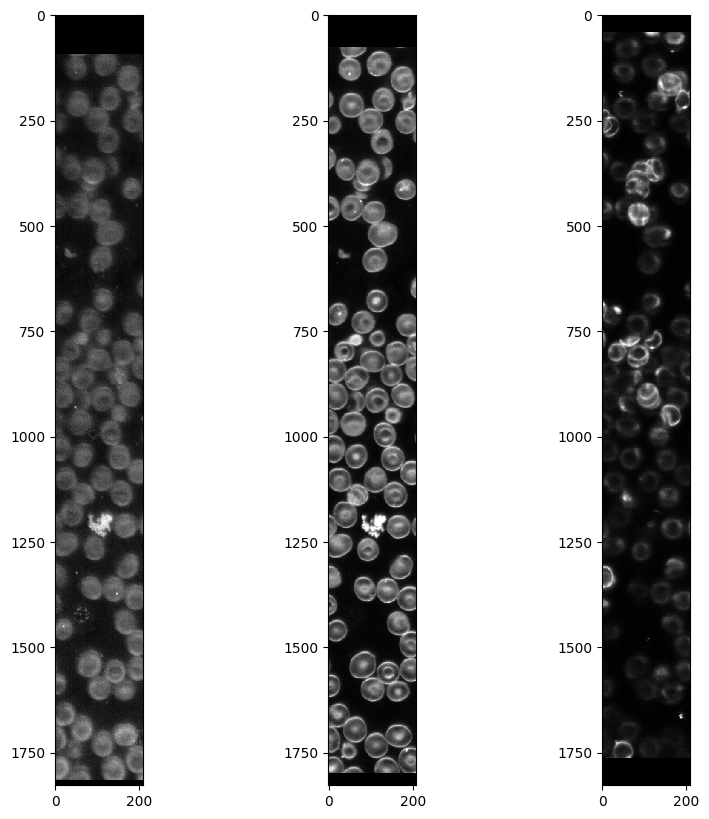

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))

cle.imshow(deskewed[5].T, plot=axs[0])
cle.imshow(deskewed[15].T, plot=axs[1])
cle.imshow(deskewed[35].T, plot=axs[2])

If we project this stack from the side, we see the deskewed tilt, especially in comparison again the projected original image

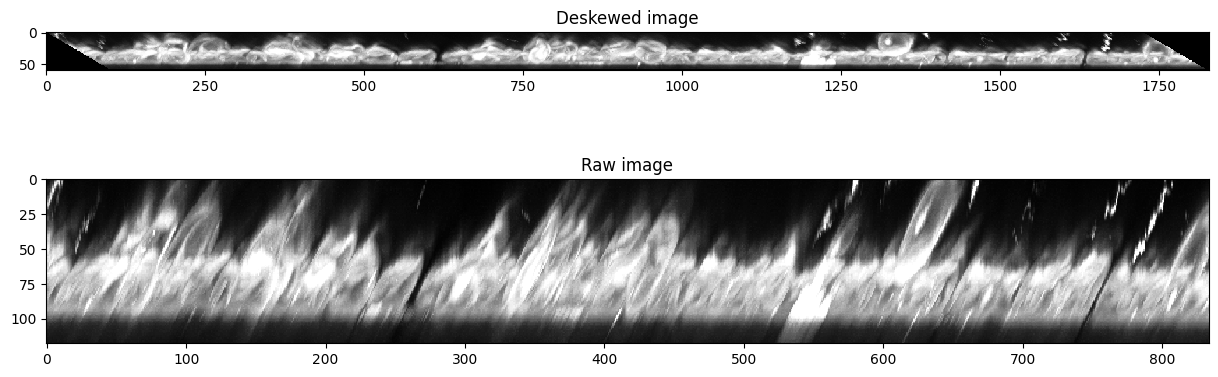

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(15,5))

cle.imshow(cle.maximum_y_projection(cle.flip(deskewed,flip_x=False)), plot=axs[0])
axs[0].title.set_text("Deskewed image")
cle.imshow(cle.maximum_y_projection(original_image).T, plot=axs[1])
axs[1].title.set_text("Raw image")

## Resampling
In case the output image becomes too huge and is oversampled anyway, one can additionally specify a scale factor to modify output image size.

(59, 209, 1828)


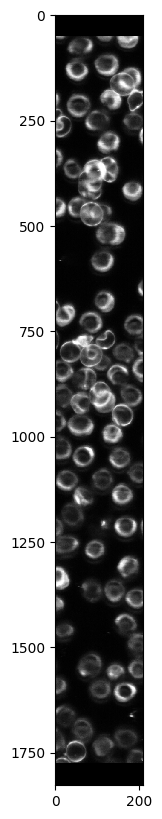

(44, 157, 1371)


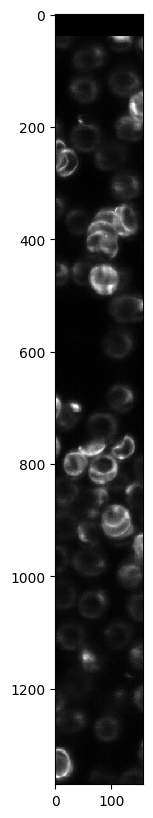

(30, 104, 914)


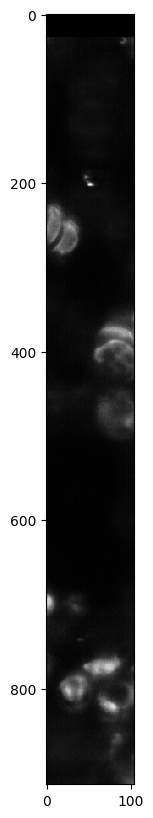

(15, 52, 457)


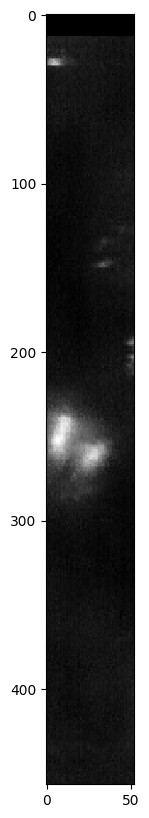

(6, 21, 183)


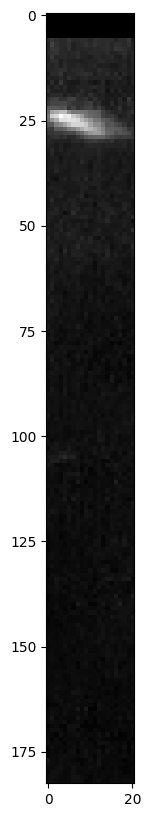

(3, 10, 91)


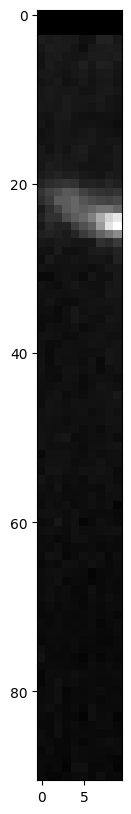

In [8]:
for scaling_factor in [1.0, 0.75, 0.5, 0.25, 0.1, 0.05]:
    deskewed_scaled = cle.deskew_x(original_image, 
                                    angle_in_degrees=deskewing_angle_in_degrees, 
                                    voxel_size_x=voxel_size_x_in_microns, 
                                    voxel_size_y=voxel_size_y_in_microns, 
                                    voxel_size_z=voxel_size_z_in_microns,
                                    scale_factor=scaling_factor
                                    )

    print(deskewed_scaled.shape)
    fig, axs = plt.subplots(1, 1, figsize=(30,10))
    cle.imshow(deskewed_scaled[int(deskewed_scaled.shape[0] / 2)].T, plot=axs)
    plt.show()